In [1]:
!mkdir ./drive/MyDrive/image_segmentation
%cd ./drive/MyDrive/image_segmentation

mkdir: cannot create directory ‘./drive/MyDrive/image_segmentation’: File exists
/content/drive/MyDrive/image_segmentation


In [2]:
from google.colab import files
files.upload()

{}

In [3]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    # image_shifted = (image_tensor + 1) / 2\
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [4]:
class EncoderBlock(nn.Module):
    def __init__(self , inn ) :
        super(EncoderBlock , self).__init__()
        self.ContractingBlock = nn.Sequential(
            nn.Conv2d(inn , 2*inn , 3 ), nn.ReLU() ,
            nn.Conv2d(2*inn , 2*inn , 3) , nn.ReLU(), 
            nn.MaxPool2d(kernel_size=(2,2), stride=2)
        )
    def forward(self , images):
        return self.ContractingBlock(images)
    def get_Self(self):
        return self

In [5]:
class DecoderBlock(nn.Module):
    def __init__(self , inn ):
        super(DecoderBlock , self).__init__()
        self.upsampling = nn.Sequential(
            nn.Upsample(scale_factor=2 , mode = 'bilinear' , align_corners=True) , 
            nn.Conv2d(inn , inn//2 , 2 ),nn.ReLU() , 
        )
        
        self.ExpandingBlock = nn.Sequential( 
            nn.Conv2d(inn , inn//2 , 3 ), nn.ReLU(),
            nn.Conv2d(inn//2 , inn//2 , 3) , nn.ReLU()
        )

    def crop_features(self ,image , new_shape):

        x  , y = image.shape[2] - new_shape[2]   , image.shape[3] -new_shape[3]
        x,y= x//2 , y // 2
        image = image[...,x:x+new_shape[2],y:y+new_shape[3]]

        return image

    def forward(self , image ,encoder_feature):
        x = self.upsampling(image)

        x = torch.cat([x , self.crop_features(encoder_feature , x.shape)] , axis = 1)
        
        return self.ExpandingBlock(x)
    def get_Self(self):
        return self




In [6]:

class final_head(nn.Module):
    def __init__(self , inn , out):
        super(final_head , self).__init__()
        self.Map = nn.Conv2d(inn , out , 1)
                             
    def forward(self , x):
        x = self.Map(x)
        return x

In [7]:
class U_Net(nn.Module):
    def __init__(self , inn , out ,hidden_channels = 64 , blocks = 4):
        super(U_Net  , self).__init__()
        self.Map_up = final_head(inn ,hidden_channels)
        self.contractingPath = nn.ModuleList([EncoderBlock(hidden_channels* (2**i)) for i in range(blocks)])
        self.ExpandingPath = nn.ModuleList([DecoderBlock(hidden_channels*(2**i)) for i in range(blocks,0,-1)])
        self.Map_down = final_head(hidden_channels , out)
        self.blocks = blocks
        self.e = {}
    def forward(self , image):
        image = self.Map_up(image)

        enc_features = {"contracting_block -1" : image}
        for i in range(self.blocks):
            image  = self.contractingPath[i](image)
            enc_features[f"contracting_block {i}"] = image
        for i in range(self.blocks):
            image = self.ExpandingPath[i](image ,enc_features[f"contracting_block {2-i}"])
        image = self.Map_down(image)
        self.e = enc_features
        return image
    def get_self(self):
        return self


In [8]:

unet = U_Net(1,3)
x = torch.randn(1, 1, 256, 256)
unet(x).shape

#>> (1, 3, 117, 117)

torch.Size([1, 3, 117, 117])

In [9]:
def crop(image , new_shape):
    x  , y = image.shape[2] - new_shape[2]   , image.shape[3] -new_shape[3]
    x,y= x//2 , y // 2
    image = image[...,x:x+new_shape[2],y:y+new_shape[3]]
    return image

In [10]:
import torch.nn.functional as F
criterion = nn.BCEWithLogitsLoss()
n_epochs = 10
input_dim = 1
label_dim = 1
display_step = 20
batch_size = 4
lr = 0.0002
initial_shape = 512
target_shape = 373
device = 'cuda'

In [11]:
from skimage import io
import numpy as np
volumes = torch.Tensor(io.imread('/content/drive/MyDrive/image_segmentation/train-volume.tif'))[:, None, :, :] / 255
labels = torch.Tensor(io.imread('/content/drive/MyDrive/image_segmentation/train-labels.tif', plugin="tifffile"))[:, None, :, :] / 255
labels = crop(labels, torch.Size([len(labels), 1, target_shape, target_shape]))
dataset = torch.utils.data.TensorDataset(volumes, labels)

In [12]:
volumes.shape

torch.Size([30, 1, 512, 512])

Epoch 0: Step 0: U-Net loss: 0.694100022315979


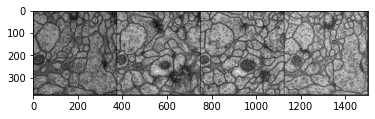

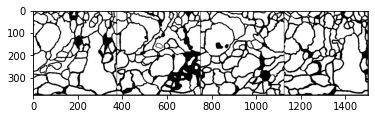

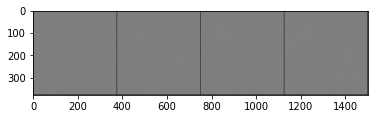

Epoch 2: Step 20: U-Net loss: 0.5231201648712158


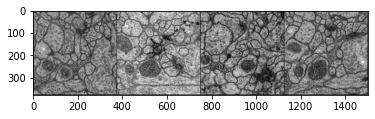

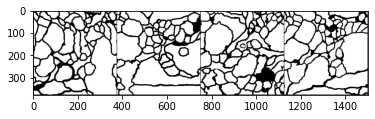

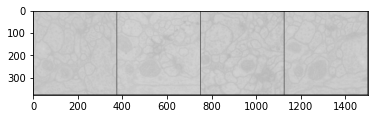

Epoch 5: Step 40: U-Net loss: 0.47244375944137573


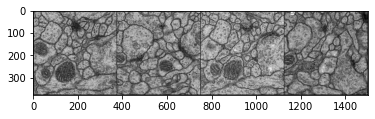

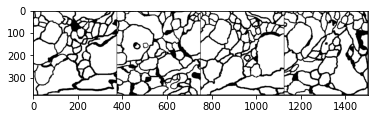

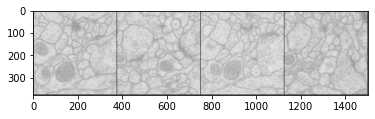

In [ ]:
def train():
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)
    unet = U_Net(input_dim, label_dim).to(device)
    unet_opt = torch.optim.Adam(unet.parameters(), lr=lr)
    cur_step = 0

    for epoch in range(n_epochs):
        for real, labels in tqdm(dataloader):
            cur_batch_size = len(real)
            # Flatten the image
            real = real.to(device)
            labels = labels.to(device)

            ### Update U-Net ###
            unet_opt.zero_grad()
            pred = unet(real)
            unet_loss = criterion(pred, labels)
            unet_loss.backward()
            unet_opt.step()

            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: U-Net loss: {unet_loss.item()}")
                show_tensor_images(
                    crop(real, torch.Size([len(real), 1, target_shape, target_shape])), 
                    size=(input_dim, target_shape, target_shape)
                )
                show_tensor_images(labels, size=(label_dim, target_shape, target_shape))
                show_tensor_images(torch.sigmoid(pred), size=(label_dim, target_shape, target_shape))
            cur_step += 1

train()